# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
dat = pd.read_csv('firms.csv')

In [3]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
4909,410,1969,-2.048750,-1.857720,-1.947300
4027,336,1975,1.194498,0.963647,1.553579
341,29,1973,-1.319290,-1.149580,-1.475360
1381,116,1969,-1.315510,-0.913922,-0.116673
2212,185,1972,-1.090630,-0.346668,-0.456894


In [4]:
dat.year.unique()

array([1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979], dtype=int64)

# Descriptives

In [5]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


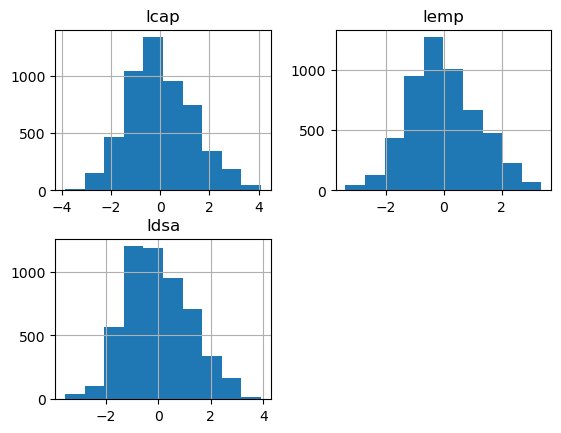

In [6]:
dat[['lcap','lemp','ldsa']].hist();

c:\Users\kzb125\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kzb125\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


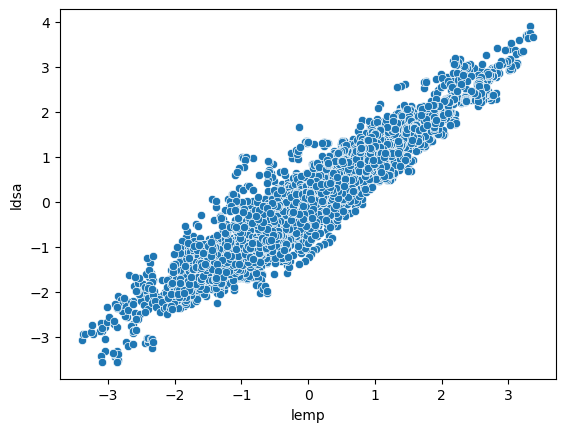

In [7]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [8]:
dat.ldsa.values.shape

(5292,)

In [9]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [10]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])